# This notebook aims to recalculate the similarity score by only comparing same-class TEs for each condition
- use human TCPS data

In [38]:
import math

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from Bio import SeqIO, pairwise2
from itertools import combinations

In [6]:
from scipy import stats

In [7]:
from matplotlib.patches import Patch

In [8]:
import os

## load all result df

In [9]:
squire_result_path = "./sequence_similarity_results/TCPS_result/"

In [10]:
fnames = os.listdir(squire_result_path)

In [13]:
fnames = pd.Series( fnames)
fnames = fnames[fnames.str.endswith("identity.csv")]

In [14]:
fnames.sort_values( inplace = True )
fnames

7         tcps_ad_up_all_pairwise_identity.csv
1          tcps_rand10_1_pairwise_identity.csv
13         tcps_rand10_2_pairwise_identity.csv
14         tcps_rand10_3_pairwise_identity.csv
2          tcps_rand20_1_pairwise_identity.csv
3          tcps_rand20_2_pairwise_identity.csv
5          tcps_rand20_3_pairwise_identity.csv
12         tcps_rand50_1_pairwise_identity.csv
8          tcps_rand50_2_pairwise_identity.csv
6          tcps_rand50_3_pairwise_identity.csv
10    tcps_ser_up_last50_pairwise_identity.csv
11     tcps_ser_up_top10_pairwise_identity.csv
4      tcps_ser_up_top20_pairwise_identity.csv
0      tcps_ser_up_top50_pairwise_identity.csv
dtype: object

In [15]:
basenames1 = [ f'rand{i}_{j}' for i in [10, 20, 50] for j in [1,2,3] ]
#basenames1

In [16]:
basenames2 =  [ 'SER_last50'] + [f'SER_top{i}' for i in [10, 20, 50 ] ] 
basenames2 

['SER_last50', 'SER_top10', 'SER_top20', 'SER_top50']

In [17]:
basenames3 = [ f'AD_top9']

In [18]:
base_all = basenames3 + basenames1 + basenames2
assert( len( base_all ) == len( fnames ) )

In [19]:
base_all

['AD_top9',
 'rand10_1',
 'rand10_2',
 'rand10_3',
 'rand20_1',
 'rand20_2',
 'rand20_3',
 'rand50_1',
 'rand50_2',
 'rand50_3',
 'SER_last50',
 'SER_top10',
 'SER_top20',
 'SER_top50']

In [20]:
df_ls = []
for f in fnames:
    d = pd.read_csv( squire_result_path + f, header = 0, index_col = None )
    df_ls.append( d )

In [21]:
df_ls[0].head()

,ID1,ID2,PercentIdentity,Alignment_str
0,L2c_97668,L2b_80878,32.629108,a-----g---c------a-ctgt-tcct----cc--a--ctcca-t...
1,L2c_97668,AluJo_63739,56.790123,-agca----ctgttcctcca-ctc---catt--tagcaat-t--a-...
2,L2c_97668,MSTB1_4089,37.662338,-agcactgttcctccactccatttagcaattatgtcaccctttttt...
3,L2c_97668,AluSz_5511,37.764350,a-g-ca-c-tg----t--tcctc--c------a----ct----c--...
4,L2c_97668,MIR_109129,64.331210,agcactgttcctccactccatttagc-aattatgtca-cc-c--tt...


In [24]:
squire_indiv = pd.read_csv("/home/lucy/Dropbox/telescope_run/genoLoc_TCPS_Deseq_indiv_locus_result.csv", header = 0, index_col = 0 )

In [26]:
squire_indiv.head()

,TE name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genoName,genoStart,genoEnd,strand,seqLen,absolute_LFC
2361,MIRb_2591,21.977249,2.001854,0.495015,4.044027,0.000053,0.008073,chr1,21875471,21875616,-,145.0,2.001854
2983,MIRb_3645,10.310570,2.238395,0.535974,4.176310,0.000030,0.005203,chr1,26188068,26188211,+,143.0,2.238395
2992,LTR10A_6,7.215176,4.566861,1.173587,3.891371,0.000100,0.013165,chr1,26268832,26269405,+,573.0,4.566861
3068,MIR_2537,1.101041,3.860287,1.037415,3.721063,0.000198,0.022386,chr1,26554369,26554498,+,129.0,3.860287
3286,AluSp_907,2.735933,3.134858,0.762647,4.110499,0.000039,0.006472,chr1,27730174,27730485,-,311.0,3.134858


## add class information to the dfs

In [27]:
deseq_df = pd.read_csv("/home/lucy/Dropbox/TCPS_TE_results/TE_indi_deseq_zc.csv", header = 0,index_col =  0)

In [28]:
deseq_df.head()

,TE name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,repName,repClass,repFamily
0,L2,0.097405,0.197787,1.457064,0.135744,0.892024,0.999991,L2,LINE,L2
1,AluSg,0.493240,1.038439,0.909837,1.141346,0.253726,0.999991,AluSg,SINE,Alu
2,L1PA8A,1.504698,-0.263127,0.834217,-0.315418,0.752444,0.999991,L1PA8A,LINE,L1
3,L1MDb,0.179092,0.166453,1.381934,0.120449,0.904127,0.999991,L1MDb,LINE,L1
4,AluSp,0.033562,0.514654,3.312685,0.155358,0.876539,0.999991,AluSp,SINE,Alu


In [32]:
deseq_df['TE name'].duplicated().sum()

0

In [33]:
repClass_dict = dict( zip( deseq_df['TE name'], deseq_df['repClass'] ))
repFamily_dict = dict( zip( deseq_df['TE name'], deseq_df['repFamily'] ))

In [34]:
def add_class_info( identity_df, repClass_dict ):
    identity_df['repClass1'] = [ repClass_dict[k] for k in identity_df['ID1'] ]
    identity_df['repClass2'] = [ repClass_dict[k] for k in identity_df['ID2'] ]
    return identity_df
    

In [35]:
for d in df_ls:
    d = add_class_info( d, repClass_dict )

In [91]:
df_ls[0].head()

,ID1,ID2,PercentIdentity,Alignment_str,repClass1,repClass2
0,L2c_97668,L2b_80878,32.629108,a-----g---c------a-ctgt-tcct----cc--a--ctcca-t...,LINE,LINE
1,L2c_97668,AluJo_63739,56.790123,-agca----ctgttcctcca-ctc---catt--tagcaat-t--a-...,LINE,SINE
2,L2c_97668,MSTB1_4089,37.662338,-agcactgttcctccactccatttagcaattatgtcaccctttttt...,LINE,LTR
3,L2c_97668,AluSz_5511,37.764350,a-g-ca-c-tg----t--tcctc--c------a----ct----c--...,LINE,SINE
4,L2c_97668,MIR_109129,64.331210,agcactgttcctccactccatttagc-aattatgtca-cc-c--tt...,LINE,SINE


## filter out different-class TEs

In [39]:
math.comb( 9, 2)

36

In [37]:
same_class_df_ls = []

for i,d in enumerate( df_ls):
    print( base_all[i] )
    print( f"Original df has {d.shape[0]} elements")
    
    d2 = d[ d['repClass1'] == d['repClass2'] ]
    same_class_df_ls.append( d2)

    print( f"Filtered df has { d2.shape[0]} elements")
    pct_left = d2.shape[0] / d.shape[0]
    print( f"{pct_left} left\n")

AD_top9
Original df has 36 elements
Filtered df has 13 elements
0.3611111111111111 left

rand10_1
Original df has 45 elements
Filtered df has 10 elements
0.2222222222222222 left

rand10_2
Original df has 45 elements
Filtered df has 16 elements
0.35555555555555557 left

rand10_3
Original df has 45 elements
Filtered df has 17 elements
0.37777777777777777 left

rand20_1
Original df has 190 elements
Filtered df has 60 elements
0.3157894736842105 left

rand20_2
Original df has 190 elements
Filtered df has 57 elements
0.3 left

rand20_3
Original df has 190 elements
Filtered df has 73 elements
0.38421052631578945 left

rand50_1
Original df has 1225 elements
Filtered df has 385 elements
0.3142857142857143 left

rand50_2
Original df has 1225 elements
Filtered df has 413 elements
0.33714285714285713 left

rand50_3
Original df has 1225 elements
Filtered df has 441 elements
0.36 left

SER_last50
Original df has 1225 elements
Filtered df has 373 elements
0.30448979591836733 left

SER_top10
Original

In [40]:
same_class_df_ls[0]

,ID1,ID2,PercentIdentity,Alignment_str,repClass1,repClass2
0,L2c_97668,L2b_80878,32.629108,a-----g---c------a-ctgt-tcct----cc--a--ctcca-t...,LINE,LINE
5,L2c_97668,L1MD_2803,47.982063,ag-----------c--act-gt---tcctcca-c----tc-cattt...,LINE,LINE
6,L2c_97668,L1ME1_20262,13.949275,---------a-g----ca-------c--t--------gt-t---c-...,LINE,LINE
7,L2c_97668,L2b_88933,47.037037,ag-ca-ctg-tt-cctcca--c-t---c-----c-att-tag-c--...,LINE,LINE
12,L2b_80878,L1MD_2803,41.784038,----tc-----t-ctgttt-cttgccc--aactgc-tccttgaacc...,LINE,LINE
13,L2b_80878,L1ME1_20262,33.786232,-tctc--t---gt-ttc-----t-t-g-----c-c---------c-...,LINE,LINE
14,L2b_80878,L2b_88933,49.295775,tctctgtttcttg-cc-c-aactgctccttgaaccccaagctccaa...,LINE,LINE
16,AluJo_63739,AluSz_5511,42.296073,ta-----a----a--aa----a-c--tt--ag---ctg-g------...,SINE,SINE
17,AluJo_63739,MIR_109129,59.259259,--taaaaaac-tt-ag-ctggtca-tggtgatgtgcacctgcagtc...,SINE,SINE
26,AluSz_5511,MIR_109129,38.368580,tggctcatgccagtaatcccagccctttgagaggctgaggcgggcg...,SINE,SINE


## make new summary df

### get related values

In [41]:
base_all

['AD_top9',
 'rand10_1',
 'rand10_2',
 'rand10_3',
 'rand20_1',
 'rand20_2',
 'rand20_3',
 'rand50_1',
 'rand50_2',
 'rand50_3',
 'SER_last50',
 'SER_top10',
 'SER_top20',
 'SER_top50']

In [42]:
num_elements = [ i for i in [10,20,50] for j in [1,2,3] ] # for the random controls
num_elements

[10, 10, 10, 20, 20, 20, 50, 50, 50]

In [43]:
# for AD and SER
num_elements = [9] + num_elements + [ 50, 10, 20, 50 ]

In [44]:
assert( len( num_elements) == len( same_class_df_ls ) )

In [45]:
len( set( df_ls[5]['ID2']).union(set( df_ls[5]['ID1'] )  ) )

20

In [97]:
len( same_class_df_ls[0]['ID1'].unique() )

7

In [46]:
summary_df = pd.DataFrame(index = 
                          ['avg_pctIdentity', 'std_pctIdentity', 'sum_pctIdentity',
                           'num_element_sampled' , 'num_combination_all',  'num_combination_left',
                           'adjusted_avg_pctIdentity'])


for i,df in enumerate( same_class_df_ls):
    # get data meta information
    f_id = base_all[i]
    num_e = num_elements[i]
    num_combination_all = df_ls[i].shape[0]
    num_combination_left = df.shape[0]
    
    #get avg and std score
    avg_score = df['PercentIdentity'].mean()
    std_score = df['PercentIdentity'].std()
    sum_score = df['PercentIdentity'].sum()
    adj_avg_score = sum_score / num_combination_all
    

    # add result to the result df
    summary_df[ f_id ] = [ avg_score, std_score, sum_score, num_e,  num_combination_all, num_combination_left,  adj_avg_score ]
    
    
    
    

### make summary df function

In [93]:
def keep_within_class_TE_pairs( df_ls, df_index_names,  verbose = True):
    """This is a helper function to filter out pair-wis comparisons that are not within the same TE repClass
    @param df_ls: a list of pair-wise indentity score dfs
    @param df_index_names: index name for each df in the df_ls
    @param verbose: set true if to print out how many combination left after filtering

    @return same_class_df_ls
    """
    same_class_df_ls = []
    for i,d in enumerate( df_ls):
                
        d2 = d[ d['repClass1'] == d['repClass2'] ]
        same_class_df_ls.append( d2)

        if( verbose): 
            print( df_index_names[i] )
            print( f"Original df has {d.shape[0]} elements")
            
            print( f"Filtered df has { d2.shape[0]} elements")
            pct_left = d2.shape[0] / d.shape[0]
            
            print( f"{pct_left} left\n")

    return same_class_df_ls

In [96]:
def get_summary_df( df_ls, df_index_names, conditions, num_elements_sampled, verbose = True):
    """ This function calculate a summary statistics from a list of  pair-wise similarity comparison result dfs. 
    It will output a summary df that includes avg. similarity scores, its std and also scores after sample-size adjustment.
    The avg. score is the avg. similarity score across all TE pairs that are WITHIN the same group ( total score / num of combinations),
    whereas the adjusted score are ( total score / number of combination for all sampled TEs ( before within-group filter)

    @param df_ls: a list of result data frames ( the pair-wise identity csvs). Note it must contains repClass information to filter out diff-class TE pairs
    @param df_index_names: the data frame index used for the summary df, usually a short of condition&sample size( eg. Rand_50 or MUT_UP_top50)
    @param conditions: experiment conditoins
    @param num_element samples: number of elements initially compared in the pair-wise comparison
    @param verbose: set True if to print out how many pair-wise combination left after filtering out diff-class TE pairs

    @return: a summary df with avg identity scores, adjusted identity scores, their std values and other related information"""

    # declare the result df
    summary_df = pd.DataFrame(index = 
                              ['avg_pctIdentity', 'std_pctIdentity', 'sum_pctIdentity',
                               'num_element_sampled' , 'num_combination_all',  'num_combination_left',
                               'adjusted_avg_pctIdentity', 'adjusted_std_pctIdentity', 'condition'])

    # filter the result df to contain only same-class TEs
    same_class_df_ls = keep_within_class_TE_pairs( df_ls, df_index_names,  verbose = verbose)
    print( len( same_class_df_ls))


    for i,df in enumerate( same_class_df_ls):
        # get data meta information
        f_id = df_index_names[i]
        num_e = num_elements_sampled[i]
        num_combination_all = math.comb( num_e, 2 )
        num_combination_left = df.shape[0]
        
        #get avg and std score
        avg_score = df['PercentIdentity'].mean()
        std_score = df['PercentIdentity'].std()
        sum_score = df['PercentIdentity'].sum()
    
        # get adjusted score information
        adj_avg_score = sum_score / num_combination_all
        adj_std = std_score * ( num_combination_left/num_combination_all ) # original std * fraction of combination remained
        
    
        # add result to the result df
        summary_df[ f_id ] = [ avg_score, std_score, sum_score, 
                              num_e,  num_combination_all, num_combination_left, 
                              adj_avg_score, adj_std, conditions[i] ]
        #print( summary_df.shape)
    
    return summary_df
    
    
    
    

In [99]:
summary_df.head()

,avg_pctIdentity,std_pctIdentity,sum_pctIdentity,num_element_sampled,num_combination_all,num_combination_left,adjusted_avg_pctIdentity,condition,adj_std_pctIdentity
AD_top9,38.734869,13.380474,503.553301,9.0,36.0,13.0,13.987592,AD_up,4.831838
rand10_1,25.040546,22.356585,250.405464,10.0,45.0,10.0,5.564566,control,4.968130
rand10_2,45.852660,24.000154,733.642553,10.0,45.0,16.0,16.303168,control,8.533388
rand10_3,29.605851,18.835619,503.299468,10.0,45.0,17.0,11.184433,control,7.115678
SER_top10,43.108842,22.412413,603.523788,10.0,45.0,14.0,13.411640,SER_up,6.972751


In [ ]:
conditions = ['AD_up'] + [ 'control' for i in range( 9) ] + [ 'SER_up' for i in range( 4)] 
len( conditions )

In [97]:
summary_df2 = get_summary_df( df_ls= df_ls, df_index_names= base_all, conditions=conditions, 
                             num_elements_sampled=num_elements, verbose= False) 

14


In [100]:
summary_df2.T.head()

,avg_pctIdentity,std_pctIdentity,sum_pctIdentity,num_element_sampled,num_combination_all,num_combination_left,adjusted_avg_pctIdentity,adjusted_std_pctIdentity,condition
AD_top9,38.734869,13.380474,503.553301,9,36,13,13.987592,4.831838,AD_up
rand10_1,25.040546,22.356585,250.405464,10,45,10,5.564566,4.96813,control
rand10_2,45.85266,24.000154,733.642553,10,45,16,16.303168,8.533388,control
rand10_3,29.605851,18.835619,503.299468,10,45,17,11.184433,7.115678,control
rand20_1,30.529265,21.327788,1831.755884,20,190,60,9.64082,6.735091,control


### format the summary df

In [48]:
conditions = ['AD_up'] + [ 'control' for i in range( 9) ] + [ 'SER_up' for i in range( 4)] 
len( conditions )

14

In [49]:
summary_df.shape

(7, 14)

In [50]:
summary_df = summary_df.T

In [51]:
summary_df['condition'] = conditions 

In [52]:
summary_df.head(2)

,avg_pctIdentity,std_pctIdentity,sum_pctIdentity,num_element_sampled,num_combination_all,num_combination_left,adjusted_avg_pctIdentity,condition
AD_top9,38.734869,13.380474,503.553301,9.0,36.0,13.0,13.987592,AD_up
rand10_1,25.040546,22.356585,250.405464,10.0,45.0,10.0,5.564566,control


In [53]:
summary_df['condition'] = pd.Categorical( summary_df['condition'], categories=['control' , 'AD_up' , 'SER_up' ] )

In [54]:
summary_df.sort_values( by = ['num_element_sampled' ,'condition'], inplace= True )

In [55]:
summary_df.index

Index(['AD_top9', 'rand10_1', 'rand10_2', 'rand10_3', 'SER_top10', 'rand20_1',
       'rand20_2', 'rand20_3', 'SER_top20', 'rand50_1', 'rand50_2', 'rand50_3',
       'SER_last50', 'SER_top50'],
      dtype='object')

In [56]:
# reordered_index = ['rand10_1', 'rand10_2', 'rand10_3', 'wt_top10', 'mut_top10', 'rand20_1',
#        'rand20_2', 'rand20_3', 'wt_top20', 'mut_top20', 'rand50_1',
#        'rand50_2', 'rand50_3', 'wt_top33', 'mut_last50', 'mut_top50']

In [57]:
#summary_df = summary_df.loc[ reordered_index ]

In [58]:
summary_df.head()

,avg_pctIdentity,std_pctIdentity,sum_pctIdentity,num_element_sampled,num_combination_all,num_combination_left,adjusted_avg_pctIdentity,condition
AD_top9,38.734869,13.380474,503.553301,9.0,36.0,13.0,13.987592,AD_up
rand10_1,25.040546,22.356585,250.405464,10.0,45.0,10.0,5.564566,control
rand10_2,45.852660,24.000154,733.642553,10.0,45.0,16.0,16.303168,control
rand10_3,29.605851,18.835619,503.299468,10.0,45.0,17.0,11.184433,control
SER_top10,43.108842,22.412413,603.523788,10.0,45.0,14.0,13.411640,SER_up


In [59]:
adjusted_std = summary_df['std_pctIdentity'] * (summary_df['num_combination_left'] / summary_df['num_combination_all']  )

In [60]:
summary_df['adj_std_pctIdentity'] = adjusted_std

## make the new bar plots

### compare number of element sampled and left after filtering

In [61]:
condition_colors = {
    'control': 'gray',
    'SER_up': 'salmon',
    'AD_up':'cornflowerblue'
}

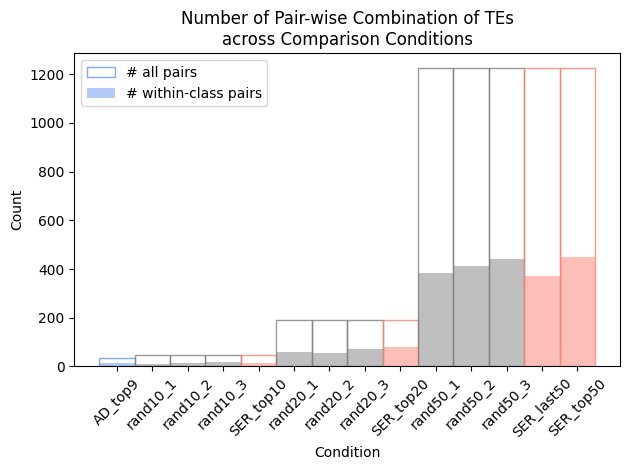

In [62]:
# Example data
x_pos = np.arange(len(summary_df.index))
heights1 = summary_df['num_combination_all']  # dataset 1
heights2 = summary_df['num_combination_left' ]   # dataset 2

all_pair_colors = [condition_colors[cond] for cond in summary_df['condition'] ]


bar_width = 1 # need to adjust

# Plot side-by-side histograms
plt.bar(x_pos , heights1, width=bar_width, label='# all pairs', alpha=0.8, edgecolor=all_pair_colors, facecolor='none',)
plt.bar(x_pos , heights2, width=bar_width, label='# within-class pairs', alpha=0.5, color =all_pair_colors)

# Add labels and legend
plt.xticks(x_pos, summary_df.index, rotation = 45)
plt.xlabel('Condition')
plt.ylabel('Count')
plt.title('Number of Pair-wise Combination of TEs\nacross Comparison Conditions')
plt.legend()
plt.tight_layout()
plt.show()


### only avg similarity score

In [63]:
# condition_colors = {
#     'control': 'gray',
#     'mutant_up': 'salmon',
#     'wt_up':'cornflowerblue'
# }

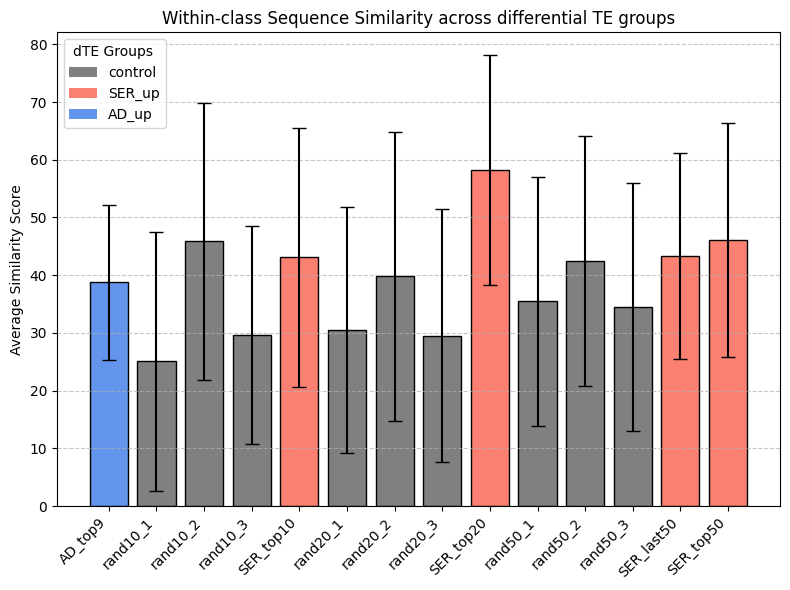

In [66]:
bar_colors = [condition_colors[cond] for cond in summary_df['condition'] ]

plt.figure(figsize=(8, 6))


plt.bar(summary_df.index, summary_df['avg_pctIdentity'] , yerr=summary_df['std_pctIdentity'], capsize=5, color=bar_colors, edgecolor='black')

plt.xticks(rotation=45, ha='right') 

legend_elements = [Patch(facecolor=color, label=cond) for cond, color in condition_colors.items()]
plt.legend(handles=legend_elements, title='dTE Groups ')


plt.ylabel('Average Similarity Score')
plt.title('Within-class Sequence Similarity across differential TE groups')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()


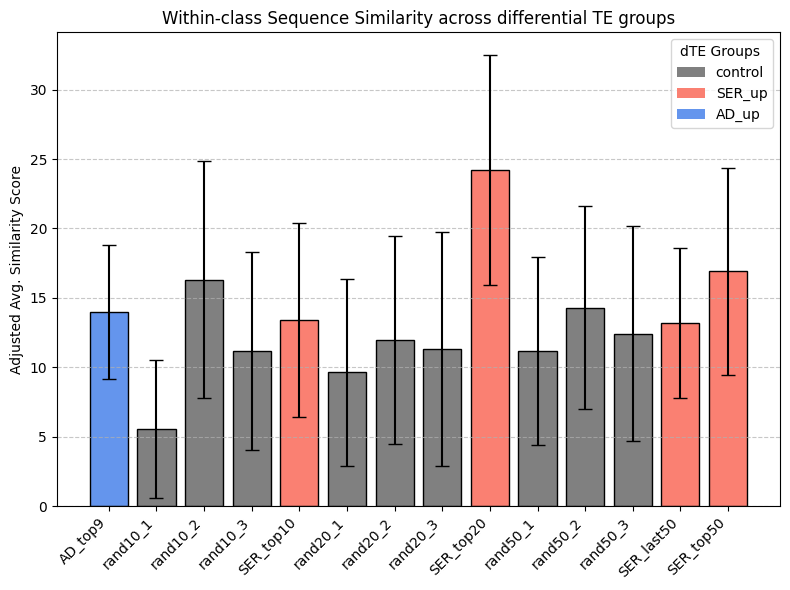

In [65]:
bar_colors = [condition_colors[cond] for cond in summary_df['condition'] ]

plt.figure(figsize=(8, 6))


plt.bar(summary_df.index, summary_df['adjusted_avg_pctIdentity'] , yerr=summary_df['adj_std_pctIdentity'], capsize=5, color=bar_colors, edgecolor='black')

plt.xticks(rotation=45, ha='right') 

legend_elements = [Patch(facecolor=color, label=cond) for cond, color in condition_colors.items()]
plt.legend(handles=legend_elements, title='dTE Groups ')

plt.ylabel('Adjusted Avg. Similarity Score')
plt.title('Within-class Sequence Similarity across differential TE groups')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()


## summary of summary ( may not be reflective to real differences though)

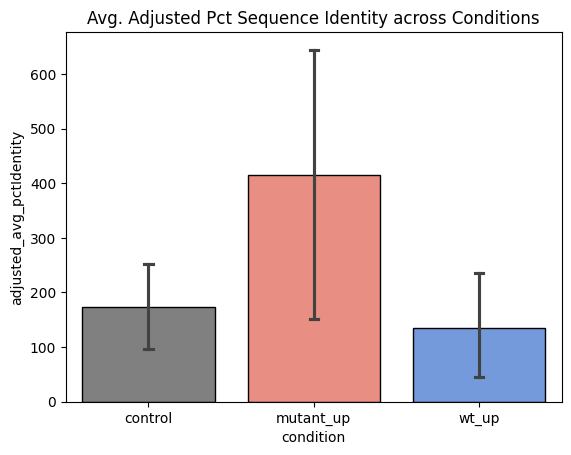

In [60]:
sns.barplot( summary_df, y ='adjusted_avg_pctIdentity' , x = 'condition' , hue= 'condition', palette= condition_colors, edgecolor = 'black', capsize = 0.05 )
plt.title( 'Avg. Adjusted Pct Sequence Identity across Conditions')
plt.show()

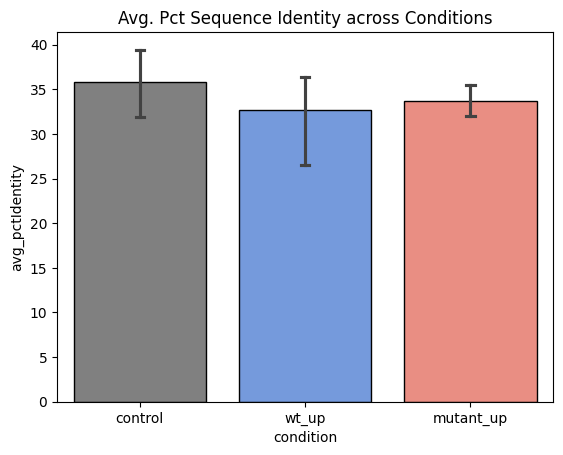

In [91]:
sns.barplot( summary_df, y ='avg_pctIdentity' , x = 'condition' , hue= 'condition', palette= condition_colors, edgecolor = 'black', capsize = 0.05 )
plt.title( 'Avg. Pct Sequence Identity across Conditions')
plt.show()

In [62]:
ctrl = summary_df['adjusted_avg_pctIdentity'][summary_df['condition'] == 'control']
mut = summary_df['adjusted_avg_pctIdentity'][summary_df['condition'] == 'mutant_up']
wt = summary_df['adjusted_avg_pctIdentity'][summary_df['condition'] == 'wt_up']

In [63]:
# Assuming equal variances (default)
t_mut_ctrl, p_mut_ctrl = stats.ttest_ind(list(mut), list( ctrl) )
t_wt_ctrl, p_wt_ctrl = stats.ttest_ind(list(wt), list( ctrl) )
t_mmut_wt, p_mut_wt = stats.ttest_ind(list(mut), list( wt) )

In [64]:
print( 'Mut vs control')
print( [t_mut_ctrl, p_mut_ctrl ] )

print( '\nWT vs control' )
print( [t_wt_ctrl, p_wt_ctrl ])

print( '\nMut vs WT' )
print( [t_mmut_wt, p_mut_wt ])

Mut vs control
[2.2167227323288476, 0.04864342607119224]

WT vs control
[-0.44934238259016424, 0.6627665327656052]

Mut vs WT
[1.6590349022026594, 0.1580047507077214]


In [93]:
ctrl0 = summary_df['avg_pctIdentity'][summary_df['condition'] == 'control']
mut0 = summary_df['avg_pctIdentity'][summary_df['condition'] == 'mutant_up']
wt0 = summary_df['avg_pctIdentity'][summary_df['condition'] == 'wt_up']

In [94]:
# Assuming equal variances (default)
t_mut_ctrl, p_mut_ctrl = stats.ttest_ind(list(mut0), list( ctrl0) )
t_wt_ctrl, p_wt_ctrl = stats.ttest_ind(list(wt0), list( ctrl0) )
t_mmut_wt, p_mut_wt = stats.ttest_ind(list(mut0), list( wt0) )

In [95]:
print( 'Mut vs control')
print( [t_mut_ctrl, p_mut_ctrl ] )

print( '\nWT vs control' )
print( [t_wt_ctrl, p_wt_ctrl ])

print( '\nMut vs WT' )
print( [t_mmut_wt, p_mut_wt ])

Mut vs control
[-0.6345261059316291, 0.5387103077583725]

WT vs control
[-0.767479381517707, 0.4605336537923542]

Mut vs WT
[0.35876917708338585, 0.7344194308076961]


## save data

In [67]:
summary_df.head()

,avg_pctIdentity,std_pctIdentity,sum_pctIdentity,num_element_sampled,num_combination_all,num_combination_left,adjusted_avg_pctIdentity,condition,adj_std_pctIdentity
AD_top9,38.734869,13.380474,503.553301,9.0,36.0,13.0,13.987592,AD_up,4.831838
rand10_1,25.040546,22.356585,250.405464,10.0,45.0,10.0,5.564566,control,4.968130
rand10_2,45.852660,24.000154,733.642553,10.0,45.0,16.0,16.303168,control,8.533388
rand10_3,29.605851,18.835619,503.299468,10.0,45.0,17.0,11.184433,control,7.115678
SER_top10,43.108842,22.412413,603.523788,10.0,45.0,14.0,13.411640,SER_up,6.972751


In [68]:
logi = pd.read_csv("./OUTPUT_EXPLAIN.csv", header = 0, index_col= 0)

In [69]:
logi.columns

Index(['count_table_indiv.csv', 'count_table_subF.csv', 'mm39_rmsk_full.tsv',
       'Deseq_indiv_locus_results.csv', 'genoLoc_Deseq_indiv_locus_result.csv',
       'compare_dTE_overlap/', 'genoLoc_TCPS_Deseq_indiv_locus_result.csv',
       'TCPS_all_Deseq_indiv_locus.csv', 'resampled_TCPS_all_TE_indi.csv',
       'TCPS_seq_similarity_summary_df.csv',
       'squire_tjp2_mut_seq_similarity_summary_df.csv',
       'squire_tjp2_wt_seq_similarity_summary_df.csv',
       'squire_tjp2_total_seq_similarity_summary_df.csv',
       'mouse_human_combined_similarity_suammry_df.csv',
       'squire_tjp2_total_seq_similarity_grouped_repClass_summary_df.csv'],
      dtype='object')

In [71]:
logi['TCPS_total_seq_similarity_grouped_repClass_summary_df.csv'] = ['8c' , 'NA' , 'seq similarity score compared between only TEs within the same repClass for human TCPS data']

In [70]:
summary_df.to_csv("./TCPS_total_seq_similarity_grouped_repClass_summary_df.csv", header = True, index = True )

In [72]:
logi.columns

Index(['count_table_indiv.csv', 'count_table_subF.csv', 'mm39_rmsk_full.tsv',
       'Deseq_indiv_locus_results.csv', 'genoLoc_Deseq_indiv_locus_result.csv',
       'compare_dTE_overlap/', 'genoLoc_TCPS_Deseq_indiv_locus_result.csv',
       'TCPS_all_Deseq_indiv_locus.csv', 'resampled_TCPS_all_TE_indi.csv',
       'TCPS_seq_similarity_summary_df.csv',
       'squire_tjp2_mut_seq_similarity_summary_df.csv',
       'squire_tjp2_wt_seq_similarity_summary_df.csv',
       'squire_tjp2_total_seq_similarity_summary_df.csv',
       'mouse_human_combined_similarity_suammry_df.csv',
       'squire_tjp2_total_seq_similarity_grouped_repClass_summary_df.csv',
       'TCPS_total_seq_similarity_grouped_repClass_summary_df.csv'],
      dtype='object')

In [73]:
logi.to_csv("OUTPUT_EXPLAIN.csv", header = True, index = True )